In [ ]:

%load_ext tensorboard

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

import datetime

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

tf.random.set_seed(123)


# Hiperparametros

In [ ]:

HEIGHT = 256
WIDTH = 256
CHANNELS = 3
LR = 1e-4
EPOCHS = 10
BATCH_SIZE = 16
KernelSize = (3, 3)

f = [16, 32, 64, 128, 256]


# Data set

## Train set

In [ ]:
path = "train/outdoor"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
train_df = pd.DataFrame(data)

train_df = train_df.sample(frac=1, random_state=42)

## Val set

In [ ]:
path = "val/outdoor"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
val_df = pd.DataFrame(data)

val_df = val_df.sample(frac=1, random_state=42)

# Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map, mask):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)

# ------------------------------------------------------------------------------

        depth_map = np.log(depth_map, where=mask>1e-4)

# ------------------------------------------------------------------------------

        depth_map = np.ma.masked_where(~mask, depth_map)

# ------------------------------------------------------------------------------

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth, where=depth_map>0))

# ------------------------------------------------------------------------------

        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                self.data["mask"][batch_id],
            )

        return x, y

In [ ]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


# visualize_samples = next(
#     iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
# )
# visualize_depth_map(visualize_samples)

# IA Definition

## Modelo

In [ ]:
inputs = Input(shape=(HEIGHT, WIDTH, CHANNELS))

x = inputs

# Encoder
# f[0]
d = Conv2D(f[0], KernelSize, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(d)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(f[0], KernelSize, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x += d

p1 = MaxPool2D((2, 2), (2, 2))(x)
c1 = x

# f[1]
d = Conv2D(f[1], KernelSize, padding='same', strides=1, activation='relu')(p1)
x = BatchNormalization()(d)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(f[1], KernelSize, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x += d

p2 = MaxPool2D((2, 2), (2, 2))(x)
c2 = x

# f[2]
d = Conv2D(f[2], KernelSize, padding='same', strides=1, activation='relu')(p2)
x = BatchNormalization()(d)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(f[2], KernelSize, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x += d

p3 = MaxPool2D((2, 2), (2, 2))(x)
c3 = x

# f[3]
d = Conv2D(f[3], KernelSize, padding='same', strides=1, activation='relu')(p3)
x = BatchNormalization()(d)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(f[3], KernelSize, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x += d

p4 = MaxPool2D((2, 2), (2, 2))(x)
c4 = x

# Bottelneck
x = Conv2D(f[4], KernelSize, padding='same', strides=1, activation='relu')(p4)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(f[4], KernelSize, padding='same', strides=1, activation='relu')(x)
x = LeakyReLU(alpha=0.2)(x)

# Decoder
# f[3]
x = UpSampling2D((2,2))(x)
concat = Concatenate()([x, c4])
x = Conv2D(f[3], KernelSize, padding='same', strides=1, activation='relu')(concat)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(f[3], KernelSize, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# f[2]
x = UpSampling2D((2,2))(x)
concat = Concatenate()([x, c3])
x = Conv2D(f[2], KernelSize, padding='same', strides=1, activation='relu')(concat)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(f[2], KernelSize, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# f[1]
x = UpSampling2D((2,2))(x)
concat = Concatenate()([x, c2])
x = Conv2D(f[1], KernelSize, padding='same', strides=1, activation='relu')(concat)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(f[1], KernelSize, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# f[0]
x = UpSampling2D((2,2))(x)
concat = Concatenate()([x, c1])
x = Conv2D(f[0], KernelSize, padding='same', strides=1, activation='relu')(concat)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(f[0], KernelSize, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(1,(1,1), padding='same', activation="tanh", name="outputs")(x)

outputs = x

model = Model(inputs,outputs)

model.summary()


## Perdida

In [ ]:
ssim_loss_weight = 0.085
l1_loss_weight = 0.01
edge_loss_weight = 0.09
loss_metric = tf.keras.metrics.Mean(name="loss")


def calculate_loss(target, pred):
    # Edges
    dy_true, dx_true = tf.image.image_gradients(target)
    dy_pred, dx_pred = tf.image.image_gradients(pred)
    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

    # Depth smoothness
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y

    depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
        abs(smoothness_y)
    )

    # Structural similarity (SSIM) index
    ssim_loss = tf.reduce_mean(
        1
        - tf.image.ssim(
            target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
        )
    )
    # Point-wise depth
    l1_loss = tf.reduce_mean(tf.abs(target - pred))

    loss = (
        (ssim_loss_weight * ssim_loss)
        + (l1_loss_weight * l1_loss)
        + (edge_loss_weight * depth_smoothness_loss)
    )

    return loss


@property
def metrics():
    return [loss_metric]


def train_step(self, batch_data):
    input, target = batch_data
    with tf.GradientTape() as tape:
        pred = self(input, training=True)
        loss = self.calculate_loss(target, pred)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_metric.update_state(loss)
    return {
        "loss": self.loss_metric.result(),
    }


def test_step(self, batch_data):
    input, target = batch_data

    pred = self(input, training=False)
    loss = self.calculate_loss(target, pred)

    self.loss_metric.update_state(loss)
    return {
        "loss": self.loss_metric.result(),
    }


In [ ]:
my_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-7,
    amsgrad = False
)

cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

# Compile the model
# model.compile(my_optimizer, loss='sparse_categorical_crossentropy')
model.compile(my_optimizer, loss=calculate_loss)

In [ ]:
train_loader = DataGenerator(
    data=train_df.reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=val_df.reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
model.fit(
    train_loader,
    epochs=EPOCHS,
    validation_data=validation_loader,
)

# Cargar modelo guardado

In [12]:
model = tf.keras.models.load_model('modelo_zero_exep.h5', custom_objects={'calculate_loss': calculate_loss})

C:\Users\nicko\AppData\Local\Temp\ipykernel_19084\3117162102.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color="black")


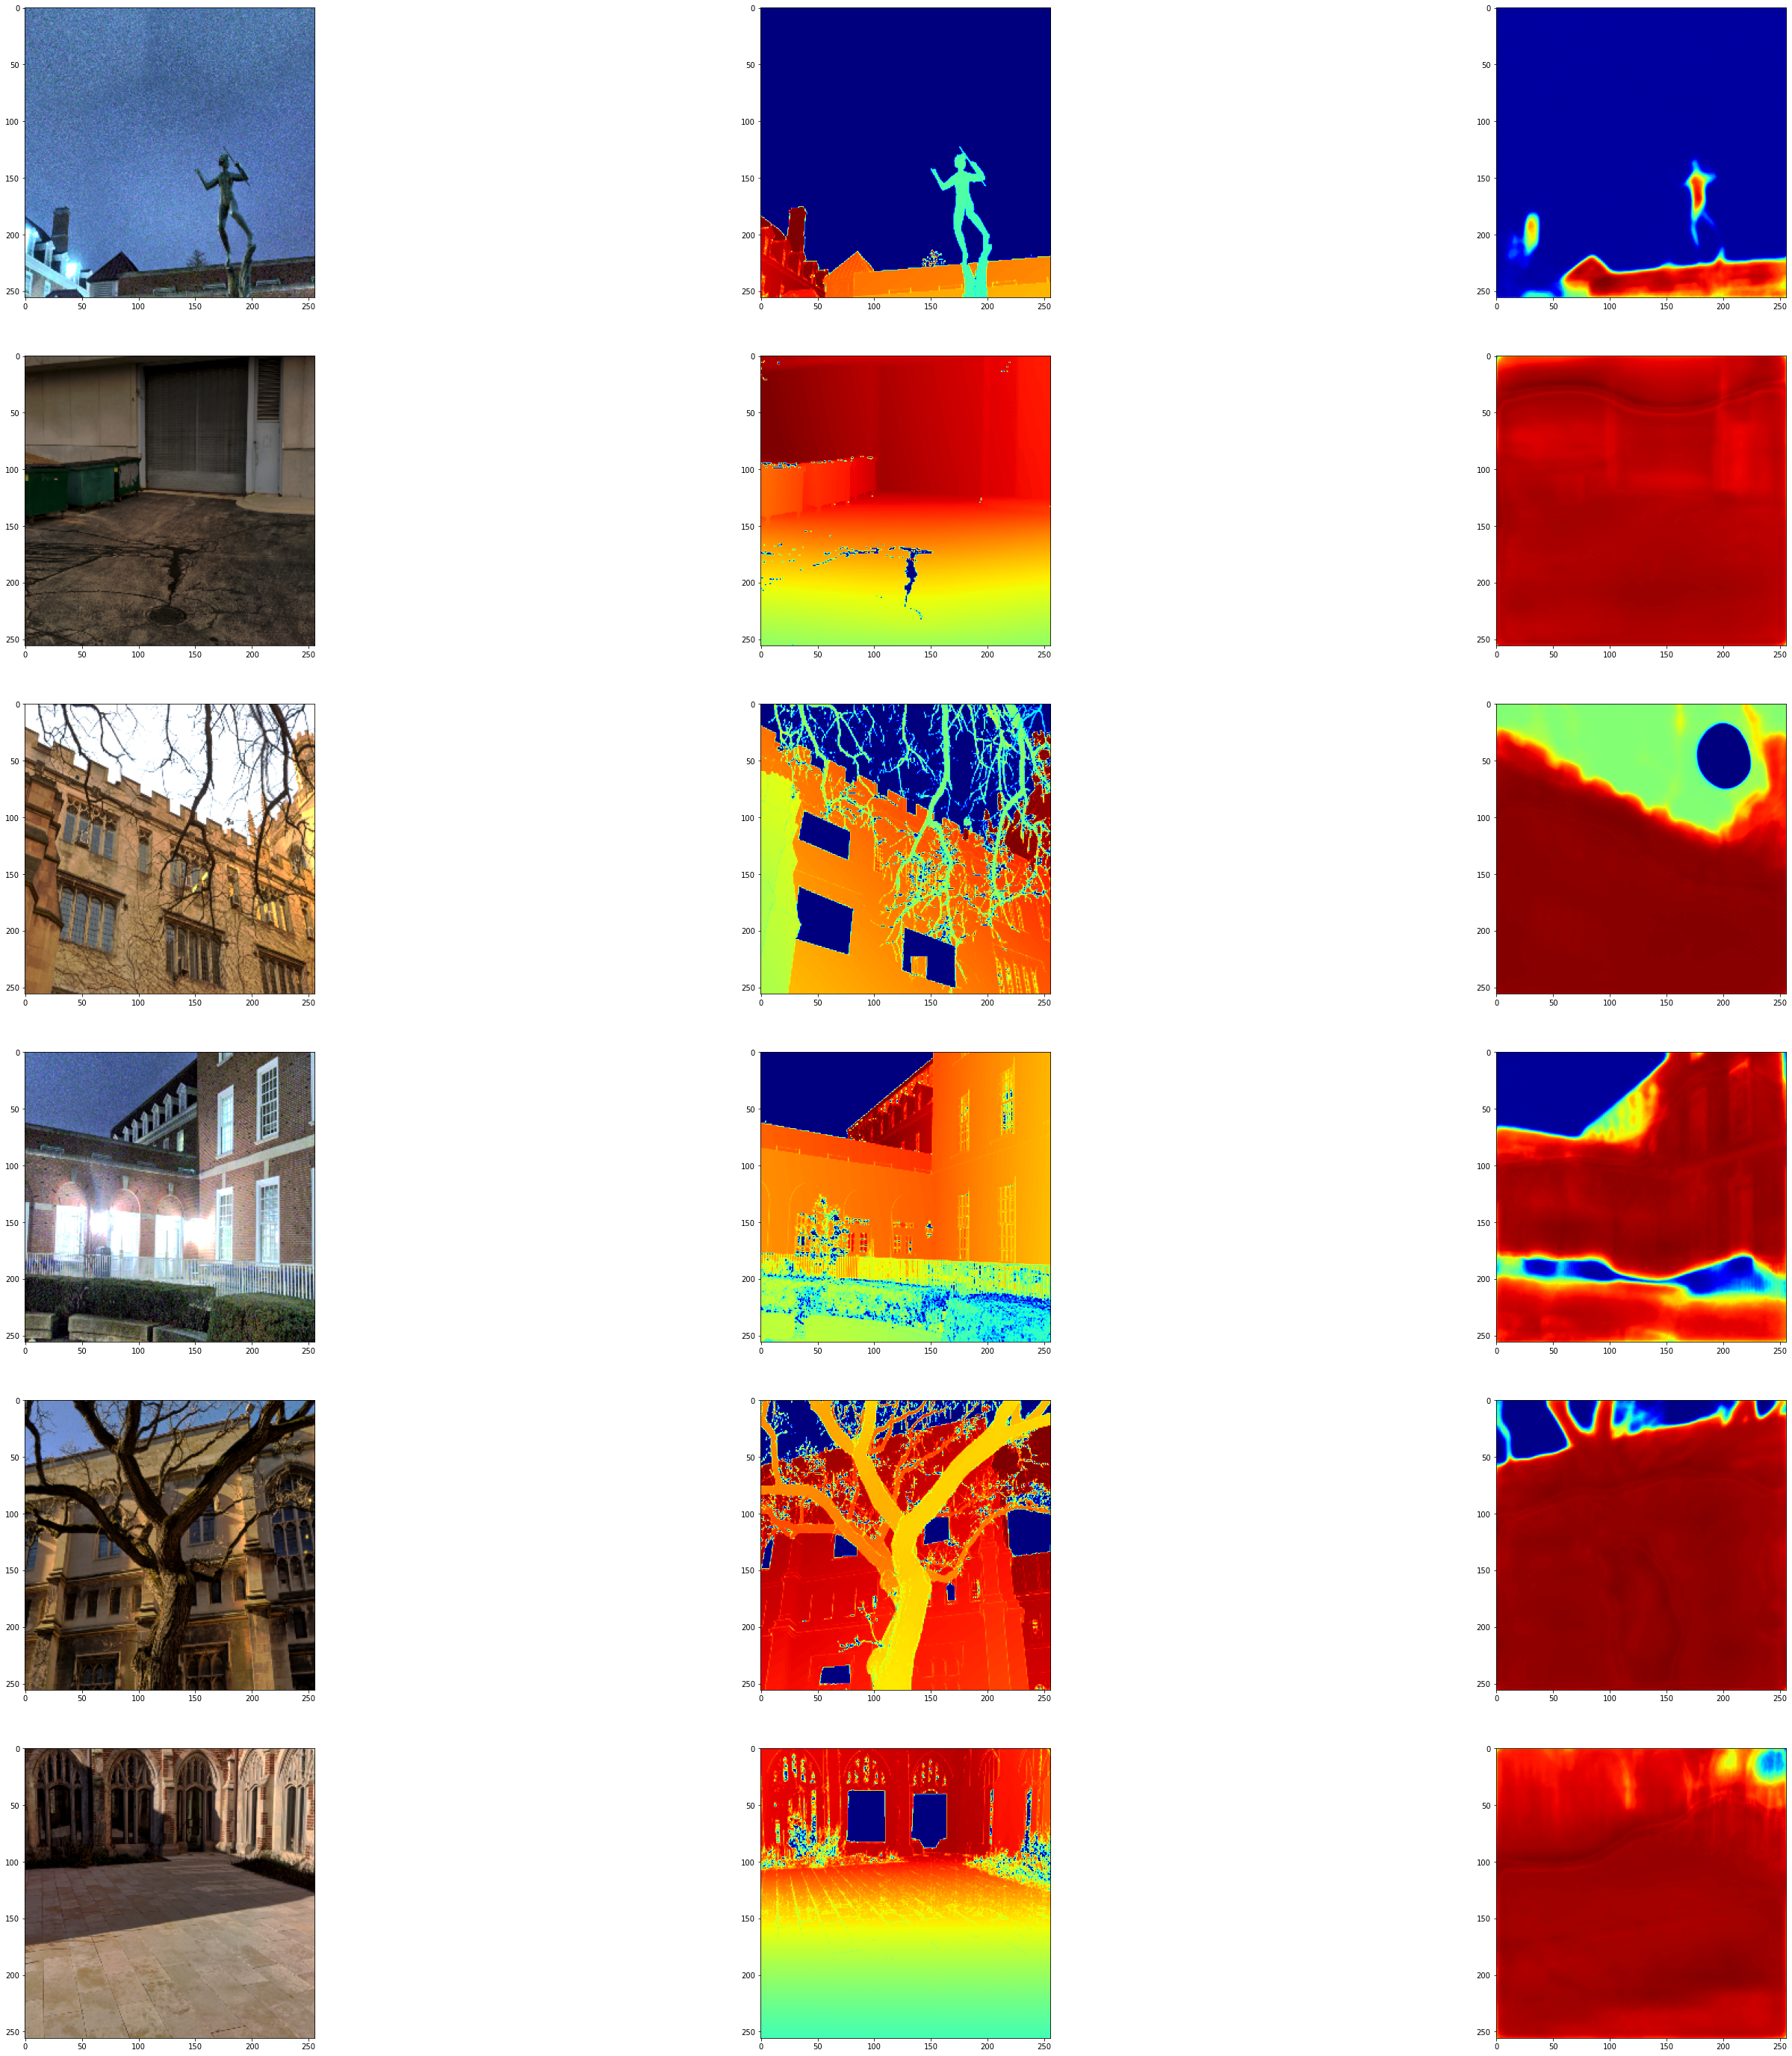

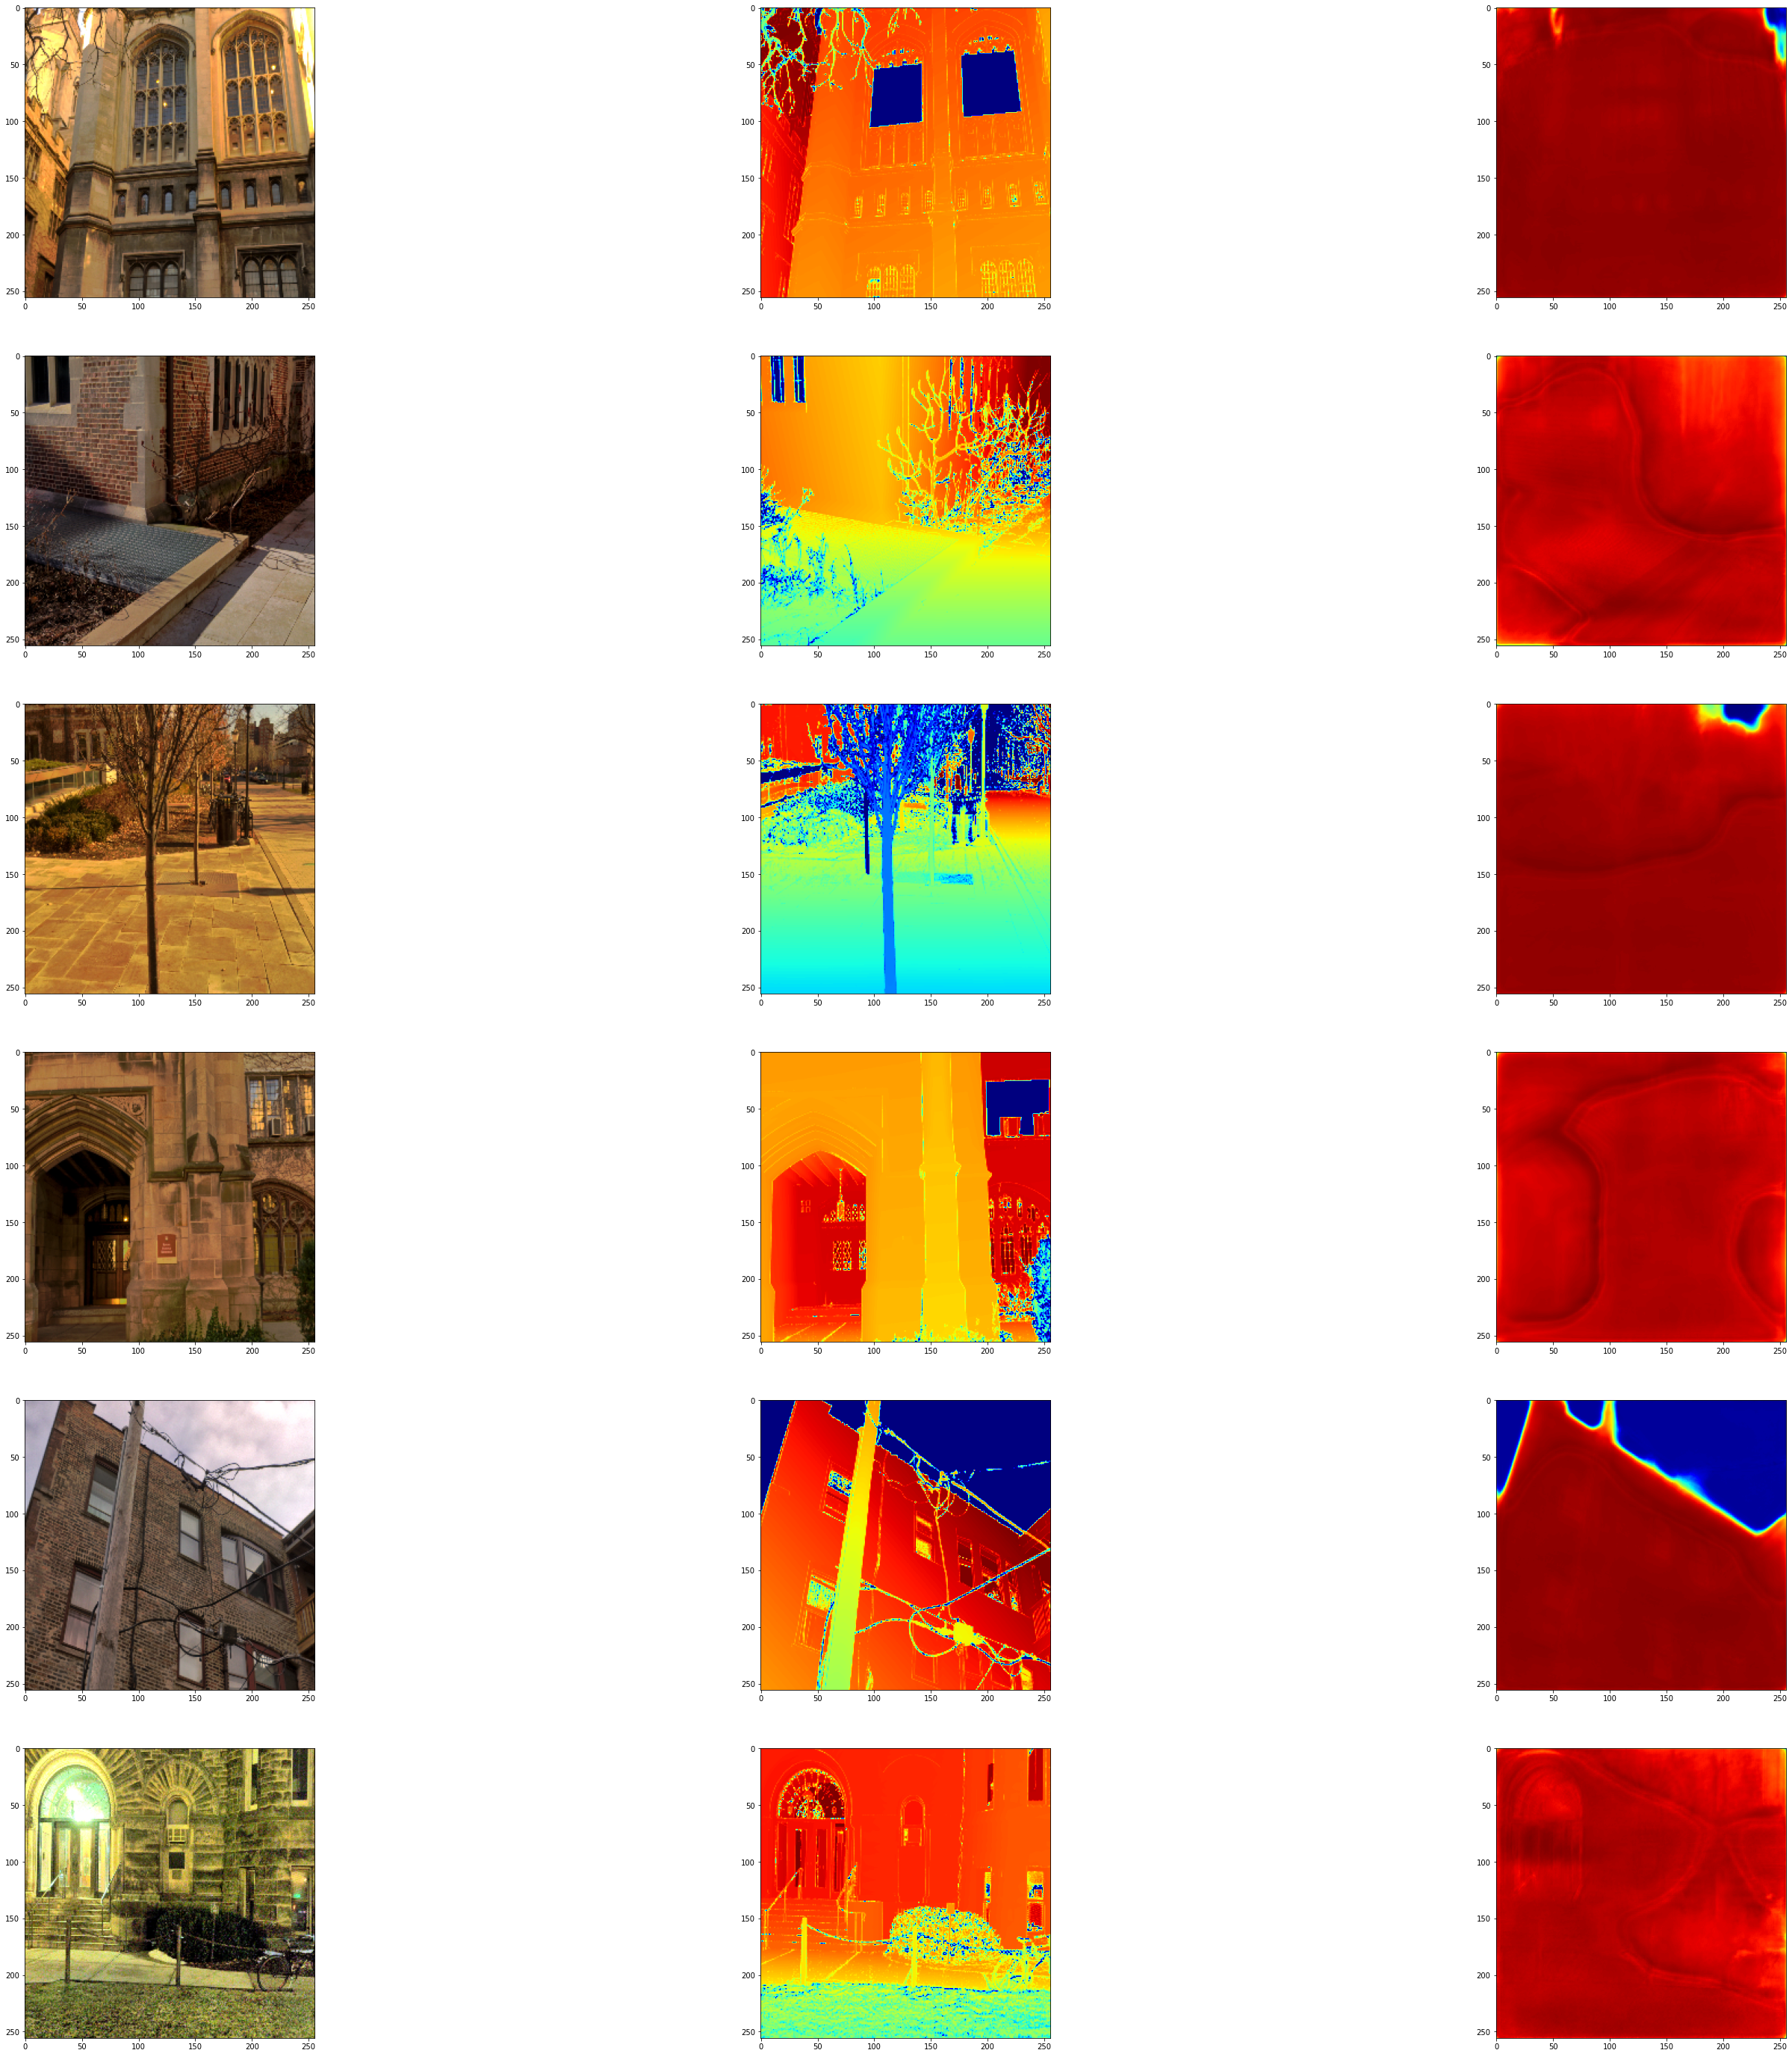

In [13]:
test_loader = next(
    iter(
        DataGenerator(
            data=val_df[265:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(
        DataGenerator(
            data=val_df[300:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

# Salvando el modelo entrenado

In [ ]:

model.save("modelo.h5")
